<a href="https://colab.research.google.com/github/irfanp056/Identity-Anomaly-Detection/blob/main/Identity_Anomaly_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---
# Brazilian Identity Document Dataset Anomaly Detecton

We are using [Brazilian-Identity-Document-Dataset](https://github.com/ricardobnjunior/Brazilian-Identity-Document-Dataset) for Data Analysis.

In [12]:
%%capture
!pip install gdown

In [13]:
# full dataset
# !gdown 1Oi88TRcpdjZmJ79WDLb9qFlBNG8q2De6

In [14]:
# sample dataset
!gdown 144EqqmMtCziua9iYo-3afUEvZrJVxUXU

Downloading...
From: https://drive.google.com/uc?id=144EqqmMtCziua9iYo-3afUEvZrJVxUXU
To: /content/BID Sample Dataset.zip
100% 71.1M/71.1M [00:00<00:00, 197MB/s]


In [15]:
%%capture
# Path
PATH = "/content/BID Sample Dataset"
!unzip "{PATH}.zip"

## Cleaning of Dataset

Note that the dataset contains different types of images: open driver's license, front driver's license, back driver's license, etc. We will select the following types of images for this case: `CNH_Frente`, `CPF_Frente` e `RG_Frente`.

In [16]:
# removing unnecessary classes
!rm -r "{PATH}/CNH_Aberta"
!rm -r "{PATH}/CNH_Verso"
!rm -r "{PATH}/CPF_Verso"
!rm -r "{PATH}/RG_Aberto"
!rm -r "{PATH}/RG_Verso"

rm: cannot remove '/content/BID Sample Dataset/CNH_Verso': No such file or directory
rm: cannot remove '/content/BID Sample Dataset/CPF_Verso': No such file or directory
rm: cannot remove '/content/BID Sample Dataset/RG_Aberto': No such file or directory
rm: cannot remove '/content/BID Sample Dataset/RG_Verso': No such file or directory


In [17]:
# removing unnecessary files
!find "{PATH}/CNH_Frente/" -maxdepth 1 -type f -name "*_ocr.txt" -delete
!find "{PATH}/CNH_Frente/" -maxdepth 1 -type f -name "*_segmentation.jpg" -delete
!ls "{PATH}/CNH_Frente/"

00003604_in.jpg  00003613_in.jpg  00003622_in.jpg  00003631_in.jpg
00003605_in.jpg  00003614_in.jpg  00003623_in.jpg  00003632_in.jpg
00003606_in.jpg  00003615_in.jpg  00003624_in.jpg  00003633_in.jpg
00003607_in.jpg  00003616_in.jpg  00003625_in.jpg  00003634_in.jpg
00003608_in.jpg  00003617_in.jpg  00003626_in.jpg  00003635_in.jpg
00003609_in.jpg  00003618_in.jpg  00003627_in.jpg  00003636_in.jpg
00003610_in.jpg  00003619_in.jpg  00003628_in.jpg  00003637_in.jpg
00003611_in.jpg  00003620_in.jpg  00003629_in.jpg  00003638_in.jpg
00003612_in.jpg  00003621_in.jpg  00003630_in.jpg  00003639_in.jpg


In [18]:
# removing unnecessary files
!find "{PATH}/CPF_Frente/" -maxdepth 1 -type f -name "*_ocr.txt" -delete
!find "{PATH}/CPF_Frente/" -maxdepth 1 -type f -name "*_segmentation.jpg" -delete
!find "{PATH}/RG_Frente/" -maxdepth 1 -type f -name "*_ocr.txt" -delete
!find "{PATH}/RG_Frente/" -maxdepth 1 -type f -name "*_segmentation.jpg" -delete

In [19]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

Populating the interactive namespace from numpy and matplotlib


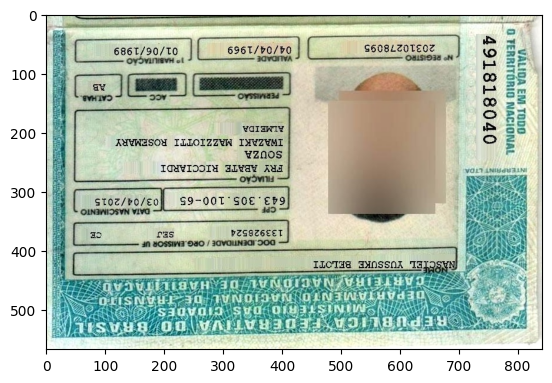

In [20]:
%pylab inline
img = mpimg.imread(f'{PATH}/CNH_Frente/00003607_in.jpg')
imgplot = plt.imshow(img)
plt.show()

In [21]:
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [22]:
import pathlib
data_dir = pathlib.Path(PATH)
data_dir

PosixPath('/content/BID Sample Dataset')

In [23]:
# dataset definitions
seed = 123
crop = False
batch_size = 32
img_height = 400
img_width = 400
validation_split = 0.2

# training set
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir, validation_split=validation_split, subset="training", seed=seed,
    image_size=(img_height, img_width), batch_size=batch_size, crop_to_aspect_ratio=crop,
)

# validation set
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir, validation_split=validation_split, subset="validation", seed=seed,
    image_size=(img_height, img_width), batch_size=batch_size, crop_to_aspect_ratio=crop,
)

Found 108 files belonging to 3 classes.
Using 87 files for training.
Found 108 files belonging to 3 classes.
Using 21 files for validation.


In [24]:
# class name
class_names = train_ds.class_names
class_names

['CNH_Frente', 'CPF_Frente', 'RG_Frente']

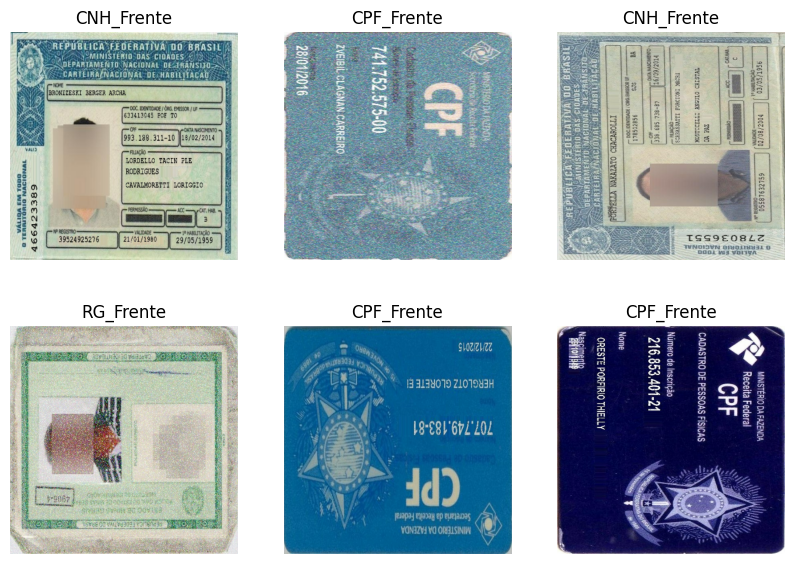

In [25]:
# viewing the training set
plt.figure(figsize=(10, 7))
for images, labels in train_ds.take(1):
  for i in range(6):
    ax = plt.subplot(2, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

---
# Machine Learning

In this section we will configure the preprocessing steps and the image classification model. Preprocessing consists of Image Augmentation and Standardization. While, the model will be a Convolutional Neural Network + Feed Forward with Dropout.

In [26]:
# configuring buffer for faster loading of images
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(seed).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Data Augmentation

To avoid overfitting, as we have a small dataset, and to increase the amount of data in the dataset; Let's conduct Augmentation on the data. We will use three types of augmentation, they are: image rotation, flipping and zoom adjustment.

>  Note: Data sharpening is disabled at test time, so input images will only be upscaled during calls to `Model.fit` on the training set.

In [27]:
# data normalization
# -- resize figures to appropriate size
# -- normalize values ​​between [0, 1]
resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(img_height, img_width),
  layers.Rescaling(1./255)
])

In [28]:
# Augmentation
data_augmentation = keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.1),
  layers.RandomZoom(0.05),
])

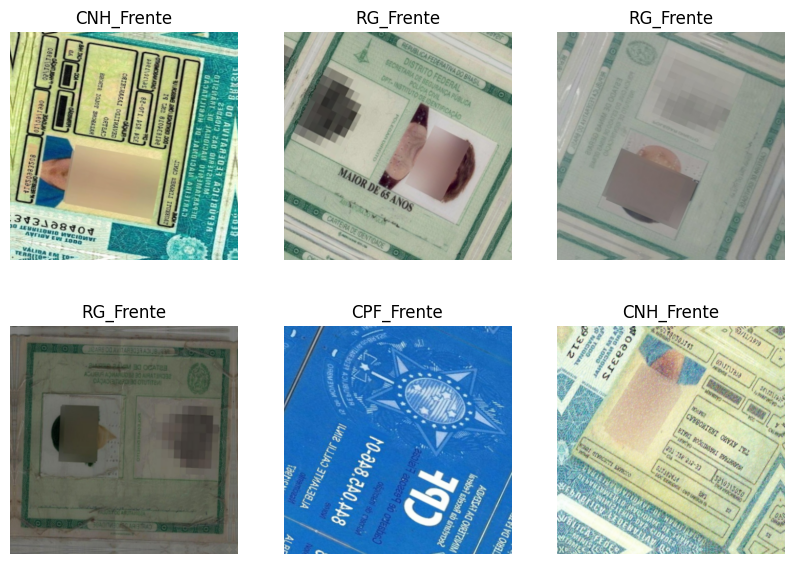

In [29]:
# Visualize the Augmentation
plt.figure(figsize=(10, 7))
for images, labels in train_ds.take(1):
  for i in range(6):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(2, 3, i + 1)
    plt.imshow(augmented_images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

## Model Construction

Our Neural Network is composed of (i) preprocessing layers (data normalization and augmentation); (ii) convolutional layers; and (iii) Feed Forward for model classification. Let us add a Dropout layer at the end of the convolutional layer to avoid overfitting in the classification network.

> Note: given that this model features data augmentation and dropout layers, its convergence is expected to be slower (i.e., more training epochs are required). However, this model will be more adaptive to real data and avoid overfitting.

In [30]:
num_classes = len(class_names)

model = Sequential([
  # preprocessamento
  data_augmentation,
  resize_and_rescale,
  # convolutional layers
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  # feed foward layers
  layers.Flatten(),
  layers.Dropout(0.3),
  layers.Dense(256, activation='relu'),
  layers.Dropout(0.3),
  layers.Dense(128, activation='relu'),
  layers.Dropout(0.3),
  layers.Dense(num_classes)
])

model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

In [31]:
# early stop, to avoid overfitting
early_stopping = keras.callbacks.EarlyStopping(
    patience=10,
    min_delta=0.001,
    restore_best_weights=True,
)

In [32]:
%%time
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=200,
    callbacks=[early_stopping]
)

Epoch 1/200
3/3 [==============================] - 29s 4s/step - loss: 1.4166 - accuracy: 0.3218 - val_loss: 0.9462 - val_accuracy: 0.3333
Epoch 2/200
3/3 [==============================] - 1s 291ms/step - loss: 0.9675 - accuracy: 0.4713 - val_loss: 1.4865 - val_accuracy: 0.3333
Epoch 3/200
3/3 [==============================] - 1s 348ms/step - loss: 1.2216 - accuracy: 0.4713 - val_loss: 0.7153 - val_accuracy: 0.4286
Epoch 4/200
3/3 [==============================] - 1s 292ms/step - loss: 0.8255 - accuracy: 0.5632 - val_loss: 0.9414 - val_accuracy: 0.3333
Epoch 5/200
3/3 [==============================] - 1s 330ms/step - loss: 0.6450 - accuracy: 0.6207 - val_loss: 0.3634 - val_accuracy: 0.9524
Epoch 6/200
3/3 [==============================] - 1s 329ms/step - loss: 0.4934 - accuracy: 0.7126 - val_loss: 0.3636 - val_accuracy: 0.9048
Epoch 7/200
3/3 [==============================] - 1s 333ms/step - loss: 0.3807 - accuracy: 0.8161 - val_loss: 0.3492 - val_accuracy: 0.8571
Epoch 8/200
3/3

In [33]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 400, 400, 3)       0         
                                                                 
 sequential (Sequential)     (None, 400, 400, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 400, 400, 128)     3584      
                                                                 
 max_pooling2d (MaxPooling2  (None, 200, 200, 128)     0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 200, 200, 64)      73792     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 100, 100, 64)      0         
 g2D)                                                 

## Model Performance

We were able to build a model with high accuracy and low overfitting bias.

> Note: we noticed that the training accuracy is problematic. This occurs due to the data augmentation and dropout layers. However, we were able to see an increasing improvement in the evaluation of the validation set.

<Axes: title={'center': 'Accuracy'}>

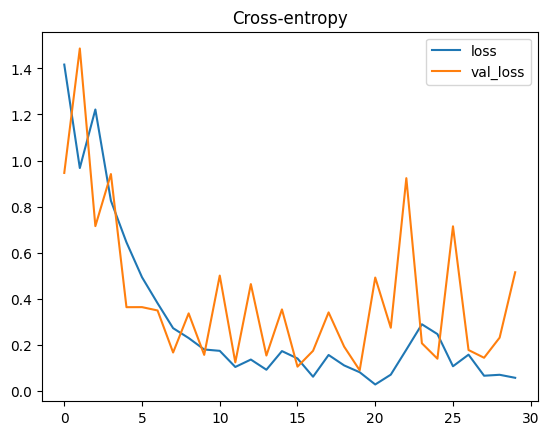

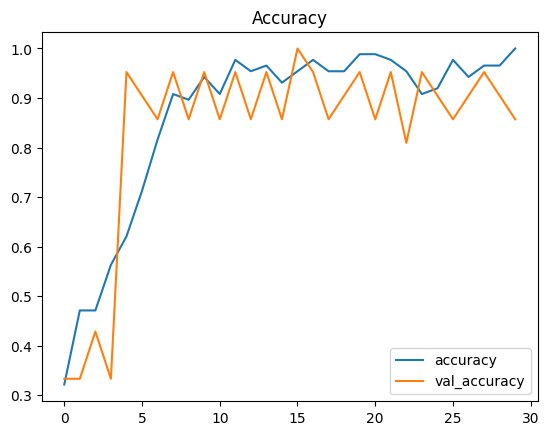

In [34]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot(title="Cross-entropy")
history_df.loc[:, ['accuracy', 'val_accuracy']].plot(title="Accuracy")

## Saving the Model

Example of model saving and loading.

In [35]:
PATH_MODEL = '/content/model_checkpoint'
model.save(
    PATH_MODEL,
    overwrite=True, include_optimizer=True, save_traces=True
)

In [36]:
# model size
!ls -lh "{PATH_MODEL}"
!du -h "{PATH_MODEL}"
# ZIP model
!zip -r model.zip "{PATH_MODEL}"

total 408K
drwxr-xr-x 2 root root 4.0K Sep 27 04:08 assets
-rw-r--r-- 1 root root   54 Sep 27 04:08 fingerprint.pb
-rw-r--r-- 1 root root  35K Sep 27 04:08 keras_metadata.pb
-rw-r--r-- 1 root root 359K Sep 27 04:08 saved_model.pb
drwxr-xr-x 2 root root 4.0K Sep 27 04:08 variables
236M	/content/model_checkpoint/variables
4.0K	/content/model_checkpoint/assets
237M	/content/model_checkpoint
  adding: content/model_checkpoint/ (stored 0%)
  adding: content/model_checkpoint/fingerprint.pb (stored 0%)
  adding: content/model_checkpoint/variables/ (stored 0%)
  adding: content/model_checkpoint/variables/variables.data-00000-of-00001 (deflated 20%)
  adding: content/model_checkpoint/variables/variables.index (deflated 65%)
  adding: content/model_checkpoint/saved_model.pb (deflated 88%)
  adding: content/model_checkpoint/keras_metadata.pb (deflated 93%)
  adding: content/model_checkpoint/assets/ (stored 0%)


### Carregando o Modelo

In [37]:
from tensorflow.keras.models import load_model

model2 = load_model('/content/model_checkpoint')
model2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 400, 400, 3)       0         
                                                                 
 sequential (Sequential)     (None, 400, 400, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 400, 400, 128)     3584      
                                                                 
 max_pooling2d (MaxPooling2  (None, 200, 200, 128)     0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 200, 200, 64)      73792     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 100, 100, 64)      0         
 g2D)                                                 